Data Preprocessing

In [2]:
import os
from google.colab import drive

drive.mount("/content/drive")
path = "/content/drive/MyDrive/Colab Notebooks//"
os.chdir(path)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

warnings.filterwarnings('ignore')

In [4]:
# Download necessary NLTK resources

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Function to preprocess text
def preprocess_text(text):
    if pd.isna(text) or text == '':
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^\w\s]', ' ', text)  # Replace special chars with space
    text = re.sub(r'\d+', ' ', text)  # Replace numbers with space

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text



In [6]:
# Function to get n-grams (either bigrams or trigrams)
def get_ngrams(text, n=2):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return [' '.join(g) for g in n_grams]


In [7]:
# Simple sentiment function (can be expanded with more sophisticated models)
def get_sentiment_score(text, pos_words, neg_words):
    if not text:
        return 0

    tokens = text.split()
    pos_count = sum(1 for word in tokens if word in pos_words)
    neg_count = sum(1 for word in tokens if word in neg_words)

    if pos_count + neg_count == 0:
        return 0
    return (pos_count - neg_count) / (pos_count + neg_count)


In [8]:
print("Reading data...")
try:
    df = pd.read_csv('imdb-data.csv')
    print(f"Dataset shape: {df.shape}")
    print(df.head())
except Exception as e:
    print(f"Error reading data: {e}")
    exit(1)


Reading data...
Dataset shape: (10009, 4)
   Ratings                                            Reviews          Movies  \
0        1  *Disclaimer: I only watched this movie as a co...  Disaster Movie   
1        1  I am writing this in hopes that this gets put ...  Disaster Movie   
2        1  Really, I could write a scathing review of thi...  Disaster Movie   
3        1  If you saw the other previous spoof movies by ...  Disaster Movie   
4        1  This movie I saw a day early for free and I st...  Disaster Movie   

                                            Resenhas  
0  * Isen√ß√£o de responsabilidade: eu s√≥ assisti e...  
1  Estou escrevendo isso na esperan√ßa de que isso...  
2  Realmente, eu poderia escrever uma cr√≠tica con...  
3  Se voc√™ viu os outros filmes falsificados ante...  
4  Este filme eu vi um dia cedo de gra√ßa e ainda ...  


In [9]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Preprocess Reviews column
print("\nPreprocessing Reviews column...")
df['Reviews_clean'] = df['Reviews'].apply(preprocess_text)
print("\nPreprocessing complete.")


Missing values in each column:
Ratings     0
Reviews     0
Movies      0
Resenhas    0
dtype: int64

Preprocessing Reviews column...

Preprocessing complete.


In [10]:
# Handle missing values
df['Reviews_clean'] = df['Reviews_clean'].fillna('')

# Remove empty reviews
empty_reviews = df[df['Reviews_clean'] == '']
print(f"\nNumber of empty reviews after preprocessing: {len(empty_reviews)}")
if len(empty_reviews) > 0:
    print("Removing empty reviews...")
    df = df[df['Reviews_clean'] != '']

# Filter out rating 6 (neutral) as per requirement
print("\nRatings distribution before filtering:")
print(df['Ratings'].value_counts().sort_index())


Number of empty reviews after preprocessing: 0

Ratings distribution before filtering:
Ratings
1      999
2     1002
3     1001
4     1001
5     1000
6     1002
7     1001
8     1001
9     1001
10    1001
Name: count, dtype: int64


In [11]:
df_filtered = df[df['Ratings'] != 6]
print("\nRatings distribution after removing neutral (rating 6):")
print(df_filtered['Ratings'].value_counts().sort_index())

print(f"Original dataset: {len(df)} reviews")
print(f"Filtered dataset (without rating 6): {len(df_filtered)} reviews")
print(f"Removed {len(df) - len(df_filtered)} reviews with rating 6")



Ratings distribution after removing neutral (rating 6):
Ratings
1      999
2     1002
3     1001
4     1001
5     1000
7     1001
8     1001
9     1001
10    1001
Name: count, dtype: int64
Original dataset: 10009 reviews
Filtered dataset (without rating 6): 9007 reviews
Removed 1002 reviews with rating 6


In [12]:
# Create binary sentiment categories
df_filtered['sentiment_category'] = df_filtered['Ratings'].apply(
    lambda x: 'Negative' if x <= 5 else 'Positive')

print("\nSentiment categories counts:")
print(df_filtered['sentiment_category'].value_counts())

# Save processed data
print("Saving processed data...")
df_filtered.to_csv('imdb-data-binary-sentiment.csv', index=False)



Sentiment categories counts:
sentiment_category
Negative    5003
Positive    4004
Name: count, dtype: int64
Saving processed data...


Data Exploration


1. Analyze Ratings Distribution
Descriptive Statistics of Ratings:
count    9007.000000
mean        5.445098
std         3.022541
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: Ratings, dtype: float64


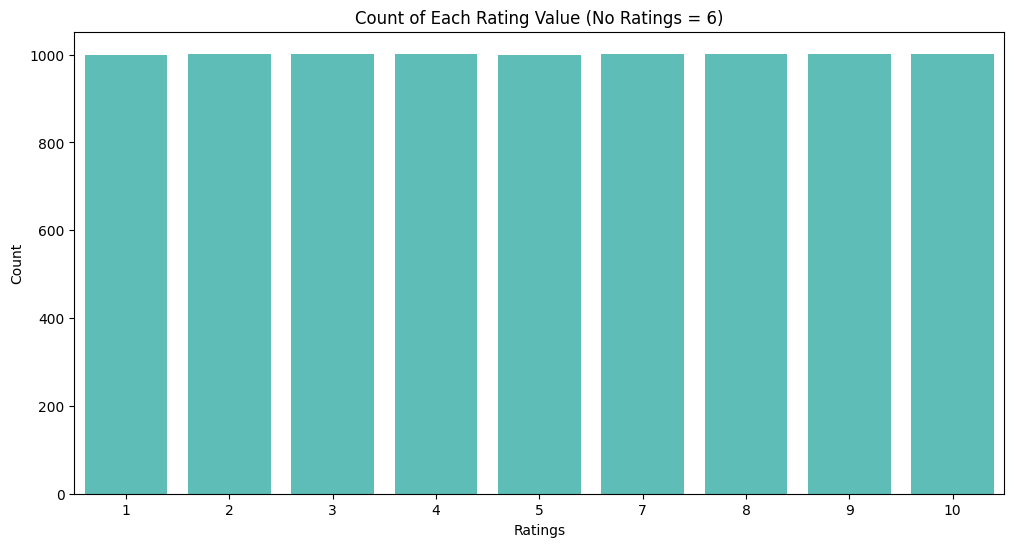

In [13]:
# 1. Analyze Ratings Distribution
print("\n1. Analyze Ratings Distribution")
print("Descriptive Statistics of Ratings:")
print(df_filtered['Ratings'].describe())

# Plot count plot for Ratings
plt.figure(figsize=(12, 6))
sns.countplot(x='Ratings', data=df_filtered, color='#4ecdc4')
plt.title('Count of Each Rating Value (No Ratings = 6)')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


2. Analyze Length of Reviews_clean

Statistics of Review Length (Characters):
count    9007.000000
mean      673.868880
std       544.436342
min        14.000000
25%       372.000000
50%       505.000000
75%       819.500000
max      6819.000000
Name: review_length, dtype: float64

Statistics of Word Count:
count    9007.000000
mean      101.002887
std        79.680739
min         1.000000
25%        57.000000
50%        76.000000
75%       122.000000
max       954.000000
Name: word_count, dtype: float64


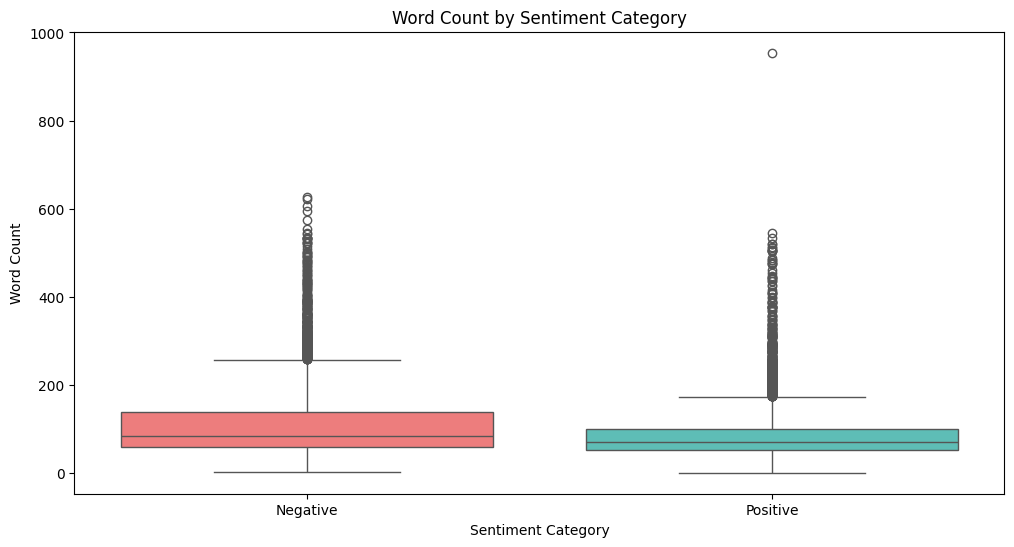

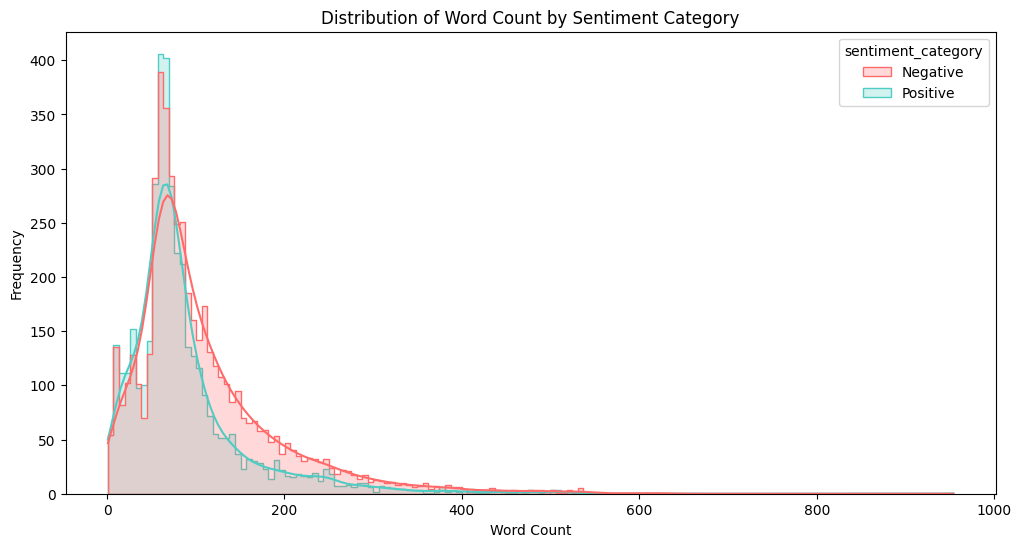

In [14]:
# 2. Analyze Length of Reviews_clean
print("\n2. Analyze Length of Reviews_clean")
df_filtered['review_length'] = df_filtered['Reviews_clean'].apply(len)
df_filtered['word_count'] = df_filtered['Reviews_clean'].apply(lambda x: len(x.split()))

print("\nStatistics of Review Length (Characters):")
print(df_filtered['review_length'].describe())

print("\nStatistics of Word Count:")
print(df_filtered['word_count'].describe())

# Plot boxplot and histogram for review length
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment_category', y='word_count', data=df_filtered,
            palette={'Negative': '#ff6b6b', 'Positive': '#4ecdc4'})
plt.title('Word Count by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Word Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df_filtered, x='word_count', hue='sentiment_category',
             element='step', kde=True, palette={'Negative': '#ff6b6b', 'Positive': '#4ecdc4'})
plt.title('Distribution of Word Count by Sentiment Category')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


3. Correlation between Review Length and Ratings


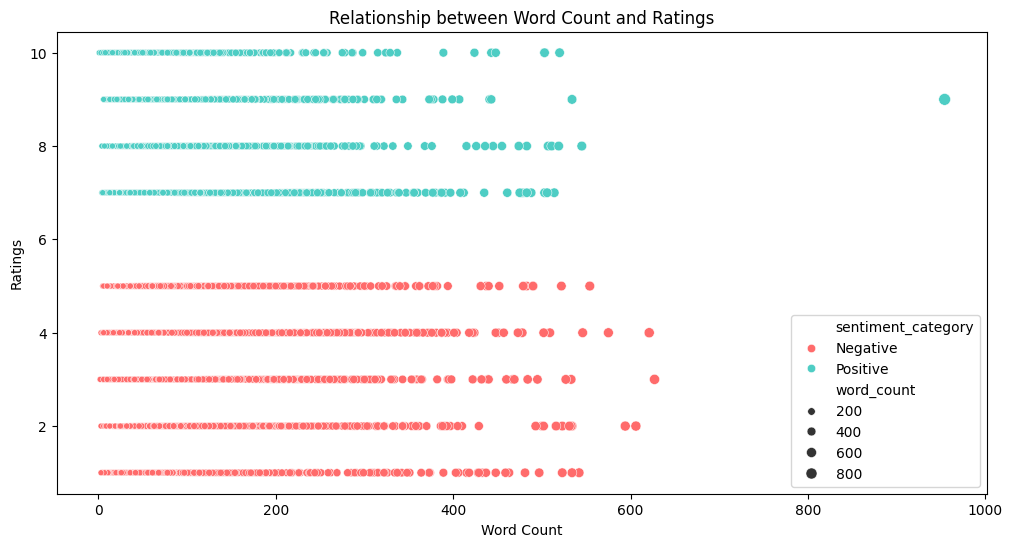

Pearson Correlation between Word Count and Ratings:
-0.12072421007041935


In [15]:
# 3. Correlation between Review Length and Ratings
print("\n3. Correlation between Review Length and Ratings")
plt.figure(figsize=(12, 6))
sns.scatterplot(x='word_count', y='Ratings', hue='sentiment_category',
                size='word_count', data=df_filtered,
                palette={'Negative': '#ff6b6b', 'Positive': '#4ecdc4'})
plt.title('Relationship between Word Count and Ratings')
plt.xlabel('Word Count')
plt.ylabel('Ratings')
plt.show()

print("Pearson Correlation between Word Count and Ratings:")
print(df_filtered['word_count'].corr(df_filtered['Ratings']))



4. Generate Word Clouds for Each Sentiment Category


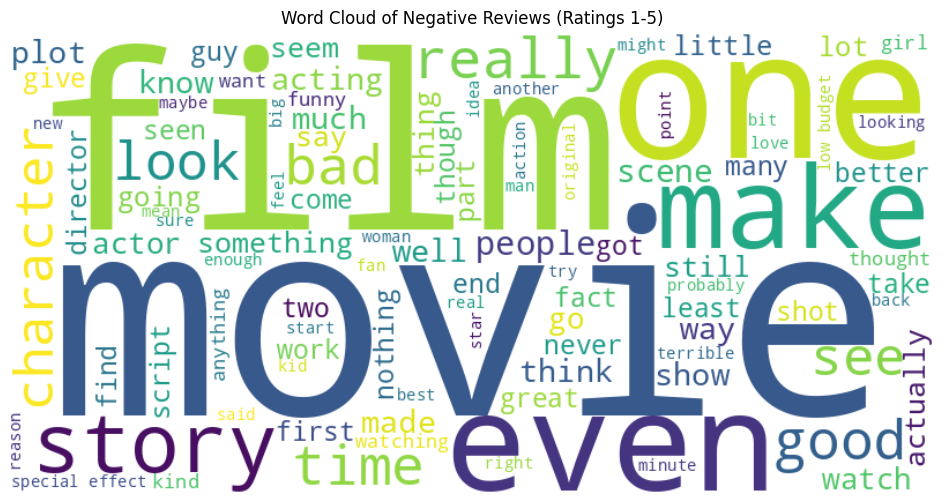

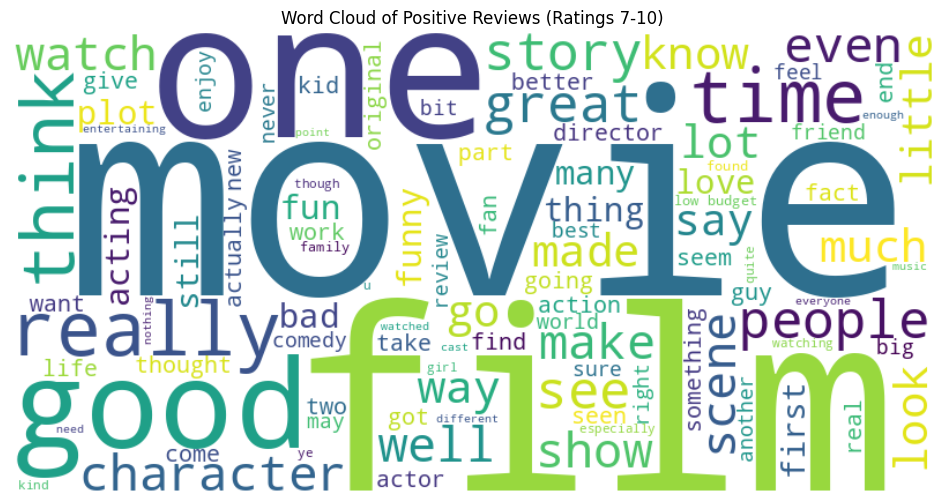

In [16]:
print("\n4. Generate Word Clouds for Each Sentiment Category")

def generate_wordcloud(df, sentiment, title):
    text = ' '.join(df[df['sentiment_category'] == sentiment]['Reviews_clean'])
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, colormap='viridis').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(df_filtered, 'Negative',
                   'Word Cloud of Negative Reviews (Ratings 1-5)')
generate_wordcloud(df_filtered, 'Positive',
                   'Word Cloud of Positive Reviews (Ratings 7-10)')



5. Find Common Bigrams and Trigrams

Top 20 2-grams Most Common in Negative Reviews:
special effect: 622
low budget: 583
look like: 529
bad movie: 439
worst movie: 323
movie ever: 308
ever seen: 270
sci fi: 267
horror movie: 258
movie like: 257
movie bad: 247
watch movie: 237
bad acting: 229
good movie: 221
year old: 220
waste time: 218
really bad: 198
one worst: 192
pretty much: 190
make movie: 187


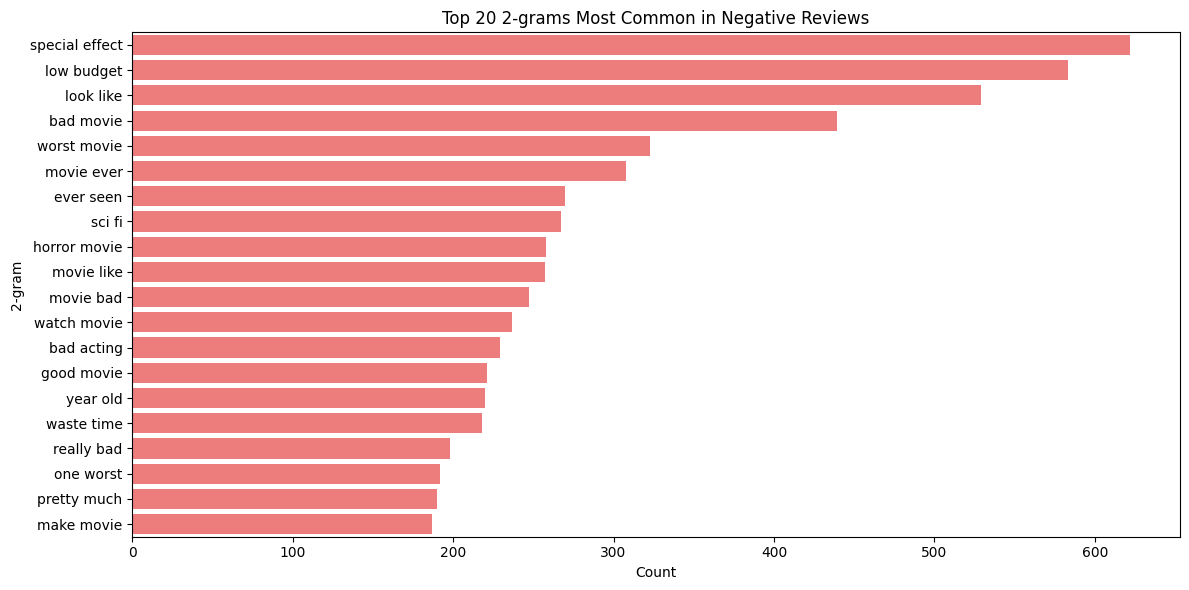


Top 20 2-grams Most Common in Positive Reviews:
low budget: 389
special effect: 335
horror movie: 223
movie like: 222
watch movie: 209
horror film: 209
movie ever: 197
see movie: 194
look like: 191
sci fi: 177
good movie: 172
ever seen: 162
great movie: 162
bad movie: 161
well done: 152
pretty good: 151
story line: 151
like movie: 146
best movie: 142
even though: 136


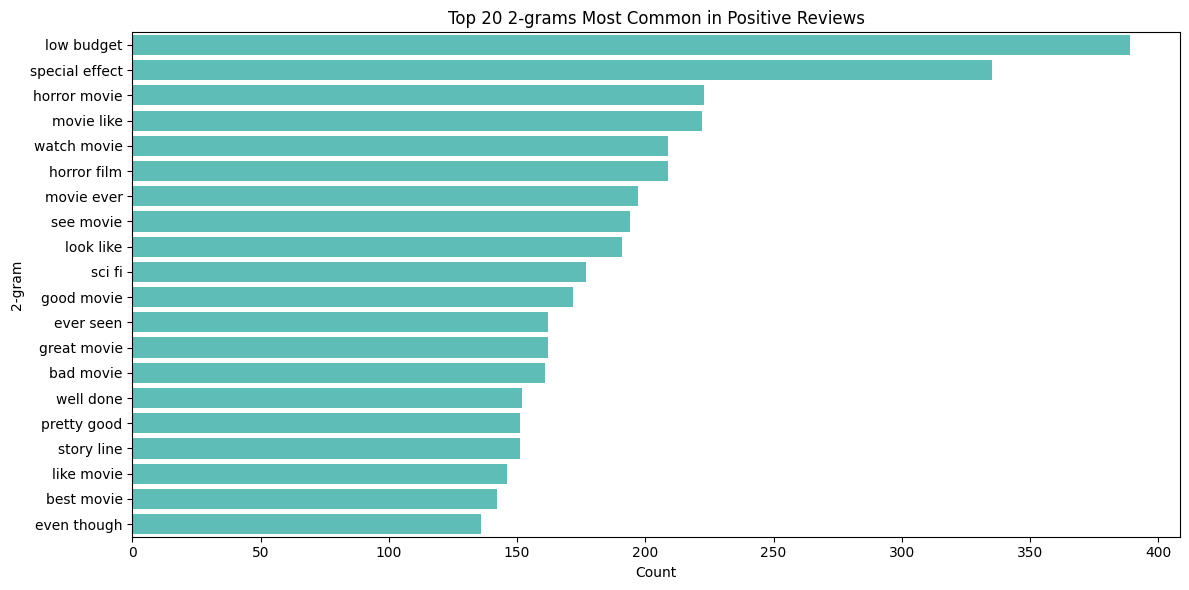


Top 20 3-grams Most Common in Negative Reviews:
worst movie ever: 193
mystery science theater: 112
movie ever seen: 108
low budget movie: 101
worst film ever: 74
movie ever made: 69
one worst movie: 68
low budget film: 63
sci fi movie: 44
film ever seen: 43
sci fi channel: 41
low budget horror: 35
manos hand fate: 34
film ever made: 34
watch watch watch: 34
night living dead: 34
mega shark v: 33
one worst film: 32
bad acting bad: 31
waste time money: 29


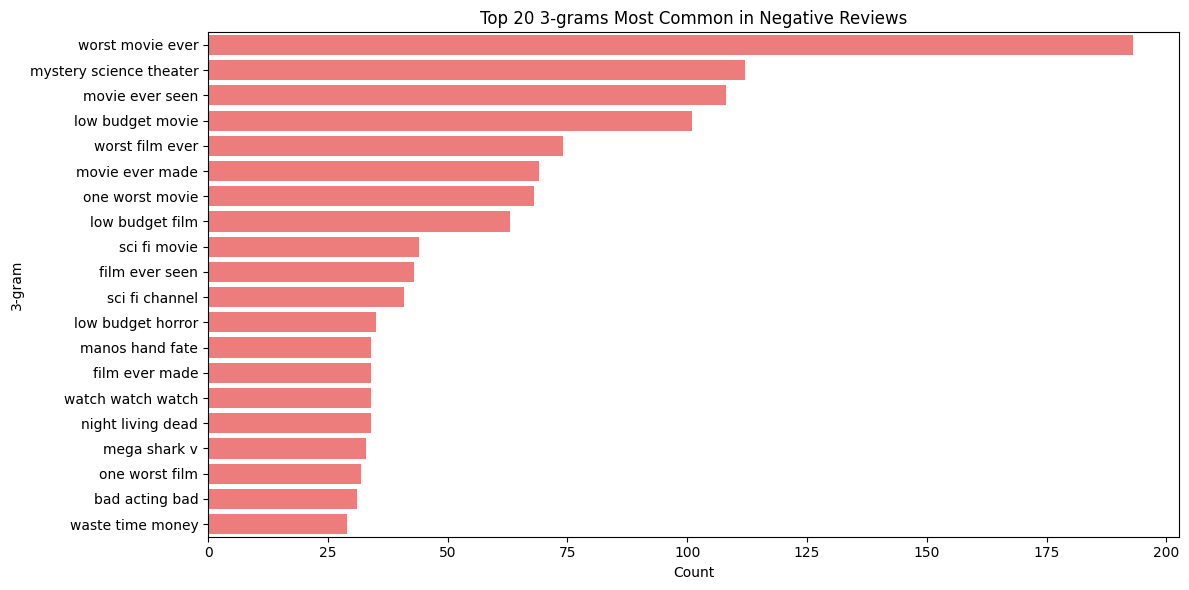


Top 20 3-grams Most Common in Positive Reviews:
movie ever seen: 61
low budget film: 58
best movie ever: 49
low budget movie: 48
movie ever made: 48
worst movie ever: 40
best movie time: 38
rated graphic violence: 37
graphic violence language: 34
time best movie: 34
movie time best: 33
go see movie: 31
low budget horror: 30
sci fi channel: 28
film ever seen: 25
film ever made: 25
really enjoyed movie: 23
sci fi film: 21
night living dead: 21
worst film ever: 20


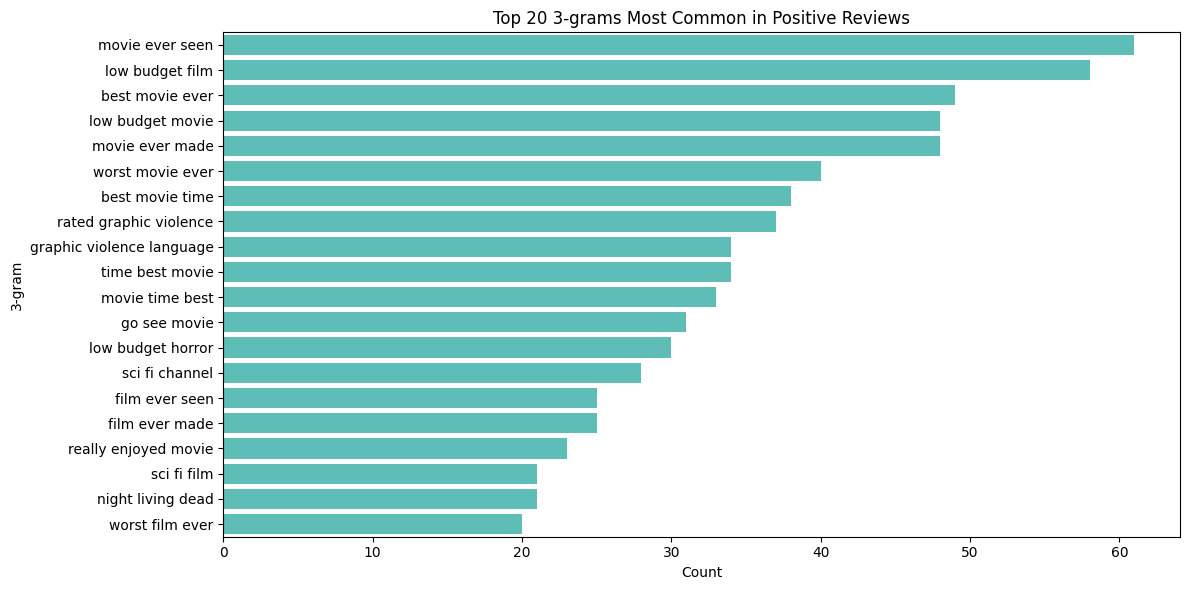

In [17]:
# 5. Find Common N-grams for Each Sentiment Category
print("\n5. Find Common Bigrams and Trigrams")

def analyze_ngrams(df, sentiment, n=2, filename_prefix=''):
    text = ' '.join(df[df['sentiment_category'] == sentiment]['Reviews_clean'])
    n_grams = get_ngrams(text, n=n)
    n_gram_counts = Counter(n_grams)

    print(f"\nTop 20 {n}-grams Most Common in {sentiment} Reviews:")
    for n_gram, count in n_gram_counts.most_common(20):
        print(f"{n_gram}: {count}")

    top_ngrams = pd.DataFrame(n_gram_counts.most_common(20), columns=[f'{n}-gram', 'Count'])
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y=f'{n}-gram', data=top_ngrams,
                palette=['#ff6b6b'] if sentiment == 'Negative' else ['#4ecdc4'])
    plt.title(f'Top 20 {n}-grams Most Common in {sentiment} Reviews')
    plt.tight_layout()
    plt.savefig(f'{filename_prefix}_{sentiment.lower()}.png')
    plt.show()

    return n_gram_counts

neg_bigrams = analyze_ngrams(df_filtered, 'Negative', n=2, filename_prefix='bigrams')
pos_bigrams = analyze_ngrams(df_filtered, 'Positive', n=2, filename_prefix='bigrams')
neg_trigrams = analyze_ngrams(df_filtered, 'Negative', n=3, filename_prefix='trigrams')
pos_trigrams = analyze_ngrams(df_filtered, 'Positive', n=3, filename_prefix='trigrams')


In [18]:
# 6. TF-IDF Analysis to Find Distinctive Words and Phrases
print("\n6. TF-IDF Analysis to Find Distinctive Words and Phrases")

def get_top_tfidf_features(texts, vectorizer, top_n=20):
    X = vectorizer.transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0).A1
    top_indices = sums.argsort()[-top_n:][::-1]
    top_features = [(feature_names[i], sums[i]) for i in top_indices]
    return top_features

negative_reviews = df_filtered[df_filtered['sentiment_category'] == 'Negative']['Reviews_clean'].tolist()
positive_reviews = df_filtered[df_filtered['sentiment_category'] == 'Positive']['Reviews_clean'].tolist()

# TF-IDF for Unigrams
word_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7)
word_vectorizer.fit(df_filtered['Reviews_clean'])

negative_words = get_top_tfidf_features(negative_reviews, word_vectorizer)
positive_words = get_top_tfidf_features(positive_reviews, word_vectorizer)

print("\nTop Distinctive Words in Negative Reviews (TF-IDF):")
for word, score in negative_words:
    print(f"{word}: {score:.4f}")

print("\nTop Distinctive Words in Positive Reviews (TF-IDF):")
for word, score in positive_words:
    print(f"{word}: {score:.4f}")



6. TF-IDF Analysis to Find Distinctive Words and Phrases

Top Distinctive Words in Negative Reviews (TF-IDF):
film: 262.4029
bad: 185.1165
one: 169.1490
like: 162.2095
good: 133.2114
even: 124.5922
time: 120.8713
really: 117.3767
make: 117.2060
acting: 116.6295
watch: 108.2631
would: 106.7334
get: 98.9289
story: 97.0210
scene: 95.9589
much: 92.9118
worst: 91.5675
thing: 91.2989
see: 90.7731
could: 89.2546

Top Distinctive Words in Positive Reviews (TF-IDF):
film: 219.8554
good: 130.0686
like: 125.0316
one: 119.2819
great: 115.7343
really: 98.8478
see: 94.6591
watch: 92.8870
people: 88.4038
time: 86.9130
well: 82.9184
story: 82.8627
think: 81.2337
show: 78.6256
would: 78.3886
get: 72.3807
make: 70.5077
fun: 69.9622
horror: 69.9255
bad: 69.6157


In [19]:
!pip install nltk
!pip install scikit-learn

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re, string, unicodedata
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import re
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [21]:
%%time
df = pd.read_csv(r"imdb-data-binary-sentiment.csv", encoding="latin-1")

CPU times: user 375 ms, sys: 38.2 ms, total: 414 ms
Wall time: 530 ms


In [22]:
df.head()

Ratings                                            Reviews          Movies  \
0        1  *Disclaimer: I only watched this movie as a co...  Disaster Movie   
1        1  I am writing this in hopes that this gets put ...  Disaster Movie   
2        1  Really, I could write a scathing review of thi...  Disaster Movie   
3        1  If you saw the other previous spoof movies by ...  Disaster Movie   
4        1  This movie I saw a day early for free and I st...  Disaster Movie   

                                            Resenhas  \
0  * Isen√É¬ß√É¬£o de responsabilidade: eu s√É¬≥ assist...   
1  Estou escrevendo isso na esperan√É¬ßa de que iss...   
2  Realmente, eu poderia escrever uma cr√É¬≠tica co...   
3  Se voc√É¬™ viu os outros filmes falsificados ant...   
4  Este filme eu vi um dia cedo de gra√É¬ßa e ainda...   

                                       Reviews_clean sentiment_category  
0  disclaimer watched movie conditional agreement...           Negative  
1  writing hope get put previous review film anyo...           Negative  
2  really could write scathing review turd sandwi...           Negative  
3  saw previous spoof movie two horrible gentlema...           Negative  
4  movie saw day early free still feel like got r...           Negative

In [23]:
df["Ratings"].describe()

count    9007.000000
mean        5.445098
std         3.022541
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: Ratings, dtype: float64

In [24]:
df["Reviews_clean"].describe()

count                                                  9007
unique                                                 8990
top       wanted watch movie thought would good intellig...
freq                                                      2
Name: Reviews_clean, dtype: object

In [25]:
print("Unique reviews:%s" % df.Reviews_clean.nunique())
print("Unique movie names:%s" % df.Movies.nunique())
print("No of ratings:%s" % df.Ratings.count())

Unique reviews:8990
Unique movie names:1756
No of ratings:9007


In [26]:
#Mapping rating data to Binary label 1 (+ve) if rating >=7 and 0 (-ve) if rating <=5 and 2 (neutral) if rating = 6
df['Label'] = df['Ratings'].apply(lambda x: '1' if x >= 7 else ('0' if x<=5 else '2'))
#Removing
df=df[df.Label<'2']
data=df[['Reviews_clean','Reviews','Ratings','Label']]
print(data['Label'].value_counts())

Label
0    5003
1    4004
Name: count, dtype: int64


In [27]:
print(data.head())

                                       Reviews_clean  \
0  disclaimer watched movie conditional agreement...   
1  writing hope get put previous review film anyo...   
2  really could write scathing review turd sandwi...   
3  saw previous spoof movie two horrible gentlema...   
4  movie saw day early free still feel like got r...   

                                             Reviews  Ratings Label  
0  *Disclaimer: I only watched this movie as a co...        1     0  
1  I am writing this in hopes that this gets put ...        1     0  
2  Really, I could write a scathing review of thi...        1     0  
3  If you saw the other previous spoof movies by ...        1     0  
4  This movie I saw a day early for free and I st...        1     0  


Model

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Gi·∫£ s·ª≠ b·∫°n ƒë√£ c√≥ d·ªØ li·ªáu ƒë√£ x·ª≠ l√Ω
data = df[['Reviews_clean', 'Label']]

# Hi·ªÉn th·ªã th√¥ng tin c∆° b·∫£n v·ªÅ d·ªØ li·ªáu
print(f"S·ªë l∆∞·ª£ng m·∫´u: {len(data)}")
print(f"Ph√¢n ph·ªëi nh√£n: \n{data['Label'].value_counts()}")
print("\nM·ªôt v√†i m·∫´u d·ªØ li·ªáu:")
print(data.head())

# Chia d·ªØ li·ªáu th√†nh t·∫≠p train v√† validation
train_text, val_text, train_labels, val_labels = train_test_split(
    data['Reviews_clean'].values,
    data['Label'].values.astype(int),  # Chuy·ªÉn v·ªÅ d·∫°ng s·ªë n·∫øu ch∆∞a ph·∫£i int
    test_size=0.25,
    random_state=42,
    stratify=data['Label'].values # Gi·ªØ nguy√™n t·ª∑ l·ªá c√°c l·ªõp trong t·∫≠p train/validation: Train: 80% 0, 20% 1, Val: 80% 0, 20% 1
)

# T·∫£i BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# Thi·∫øt l·∫≠p ƒë·ªô d√†i t·ªëi ƒëa
MAX_LEN = 256

# Tokenize v√† chu·∫©n b·ªã input cho BERT
# Tokenization nhanh h∆°n
def convert_to_bert_input(texts):
    encoded = tokenizer.batch_encode_plus(
        texts.tolist(),  # Chuy·ªÉn v·ªÅ list n·∫øu ch∆∞a ph·∫£i
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding="max_length",
        truncation=True,
        return_attention_mask=True, # Tr·∫£ v·ªÅ mask ƒë·ªÉ b·ªè qua ph·∫ßn ƒë·ªám
        return_tensors="pt" # Tr·∫£ v·ªÅ tensor PyTorch
    )
    return encoded["input_ids"], encoded["attention_mask"]

# Tokenize d·ªØ li·ªáu train v√† validation
print("Tokenizing d·ªØ li·ªáu...")
train_inputs, train_masks = convert_to_bert_input(train_text)
val_inputs, val_masks = convert_to_bert_input(val_text)

# Chuy·ªÉn labels th√†nh tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Ki·ªÉm tra k√≠ch th∆∞·ªõc c·ªßa d·ªØ li·ªáu ƒë√£ x·ª≠ l√Ω
print(f'Train inputs shape: {train_inputs.shape}')
print(f'Train masks shape: {train_masks.shape}')
print(f'Train labels shape: {train_labels.shape}')

# T·∫°o batch size
batch_size = 16

# V·∫•n ƒë·ªÅ: PyTorch y√™u c·∫ßu d·ªØ li·ªáu ƒë·∫ßu v√†o ph·∫£i ·ªü d·∫°ng torch.Tensor v√† ƒë∆∞·ª£c t·ªï ch·ª©c theo batch.
# D·∫°ng tensor l√† m·ªôt c·∫•u tr√∫c d·ªØ li·ªáu ƒëa chi·ªÅu ‚Äî b·∫°n c√≥ th·ªÉ hi·ªÉu n√¥m na n√≥ l√† m·ªôt phi√™n b·∫£n m·ªü r·ªông c·ªßa ma tr·∫≠n
# torch.Tensor l√† ƒë·ªëi t∆∞·ª£ng ch√≠nh ƒë·ªÉ ch·ª©a v√† x·ª≠ l√Ω d·ªØ li·ªáu gi·ªëng nh∆∞ numpy.array, nh∆∞ng h·ªó tr·ª£ th√™m:
  # TƒÉng t·ªëc b·∫±ng GPU
  # T·ª± ƒë·ªông lan truy·ªÅn gradient ƒë·ªÉ hu·∫•n luy·ªán m√¥ h√¨nh
# Gi·∫£i ph√°p: DataLoader t·ª± ƒë·ªông ƒë√≥ng g√≥i d·ªØ li·ªáu th√†nh tensor v√† cung c·∫•p iterator ƒë∆°n gi·∫£n ƒë·ªÉ s·ª≠ d·ª•ng trong v√≤ng l·∫∑p hu·∫•n luy·ªán. => X·ª≠ l√Ω theo batch (Batching), X√°o tr·ªôn d·ªØ li·ªáu
# T·∫°o DataLoader cho t·∫≠p train
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# T·∫°o DataLoader cho t·∫≠p validation
validation_data = TensorDataset(val_inputs, val_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

print("Ho√†n th√†nh vi·ªác chu·∫©n b·ªã d·ªØ li·ªáu cho BERT!")

# Hi·ªÉn th·ªã m·ªôt m·∫´u ƒë√£ ƒë∆∞·ª£c tokenize
print("\nV√≠ d·ª• v·ªÅ m·ªôt ƒëo·∫°n vƒÉn ƒë√£ ƒë∆∞·ª£c tokenize:")
example_text = data['Reviews_clean'].values[0]
print(f"VƒÉn b·∫£n g·ªëc: {example_text[:100]}...")

example_encoded = tokenizer.encode_plus(
    example_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

print(f"Token IDs: {example_encoded['input_ids'][0][:20]}...")
print(f"Attention mask: {example_encoded['attention_mask'][0][:20]}...")

# Gi·∫£i m√£ tokens ƒë·ªÉ hi·ªÉn th·ªã
tokens = tokenizer.convert_ids_to_tokens(example_encoded['input_ids'][0])
print(f"Tokens: {tokens[:20]}...")


S·ªë l∆∞·ª£ng m·∫´u: 9007
Ph√¢n ph·ªëi nh√£n: 
Label
0    5003
1    4004
Name: count, dtype: int64

M·ªôt v√†i m·∫´u d·ªØ li·ªáu:
                                       Reviews_clean Label
0  disclaimer watched movie conditional agreement...     0
1  writing hope get put previous review film anyo...     0
2  really could write scathing review turd sandwi...     0
3  saw previous spoof movie two horrible gentlema...     0
4  movie saw day early free still feel like got r...     0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Tokenizing d·ªØ li·ªáu...
Train inputs shape: torch.Size([6755, 256])
Train masks shape: torch.Size([6755, 256])
Train labels shape: torch.Size([6755])
Ho√†n th√†nh vi·ªác chu·∫©n b·ªã d·ªØ li·ªáu cho BERT!

V√≠ d·ª• v·ªÅ m·ªôt ƒëo·∫°n vƒÉn ƒë√£ ƒë∆∞·ª£c tokenize:
VƒÉn b·∫£n g·ªëc: disclaimer watched movie conditional agreement see film free caught dead giving hard earned money id...
Token IDs: tensor([  101,  5860, 19771,  5017,  3427,  3185, 18462,  3820,  2156,  2143,
         2489,  3236,  2757,  3228,  2524,  3687,  2769, 10041,  2092,  4863])...
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])...
Tokens: ['[CLS]', 'disc', '##lai', '##mer', 'watched', 'movie', 'conditional', 'agreement', 'see', 'film', 'free', 'caught', 'dead', 'giving', 'hard', 'earned', 'money', 'idiot', 'well', 'explain']...


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig
from transformers import DistilBertModel, DistilBertConfig
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# üî• S·ª≠ d·ª•ng DistilBERT thay v√¨ BERT
class DistilBertForSentimentAnalysis(nn.Module):
    def __init__(self, freeze_bert=False):
        super(DistilBertForSentimentAnalysis, self).__init__()

        # Load pre-trained DistilBERT
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze BERT n·∫øu c·∫ßn
        if freeze_bert:
            for param in self.distilbert.parameters():
                param.requires_grad = False

        # Classification layer
        self.dropout = nn.Dropout(0.2)  # Gi·∫£m dropout
        self.classifier = nn.Linear(768, 2)  # Binary classification, L·ªõp ph√¢n lo·∫°i cu·ªëi c√πng v·ªõi ƒë·∫ßu v√†o 768 chi·ªÅu (k√≠ch th∆∞·ªõc ƒë·∫ßu ra c·ªßa DistilBERT) v√† ƒë·∫ßu ra 2 l·ªõp (v√≠ d·ª•: t√≠ch c·ª±c/ti√™u c·ª±c)

    def forward(self, input_ids, attention_mask):
        # Truy·ªÅn input qua DistilBERT
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)

        # L·∫•y hidden state c·ªßa [CLS] token ƒë·∫ßu ti√™n (DistilBERT kh√¥ng c√≥ pooler_output), l√†m ƒë·∫°i di·ªán cho c·∫£ c√¢u
        pooled_output = outputs.last_hidden_state[:, 0, :]

        # Dropout + classification
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits
    

# Kh·ªüi t·∫°o model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"ƒêang s·ª≠ d·ª•ng thi·∫øt b·ªã: {device}")

# Thi·∫øt l·∫≠p m√¥ h√¨nh v·ªõi t√πy ch·ªçn freeze_bert=False ƒë·ªÉ fine-tune to√†n b·ªô m√¥ h√¨nh
model = DistilBertForSentimentAnalysis(freeze_bert=False)
model.to(device)

# T√≥m t·∫Øt ki·∫øn tr√∫c m√¥ h√¨nh
print("===== Ki·∫øn tr√∫c m√¥ h√¨nh =====")
print(model)

# Thi·∫øt l·∫≠p optimizer v√† learning rate
# Th∆∞·ªùng learning rate nh·ªè ƒë∆∞·ª£c s·ª≠ d·ª•ng cho fine-tuning BERT

# Thi·∫øt l·∫≠p learning rate kh√°c nhau cho c√°c ph·∫ßn kh√°c nhau c·ªßa m√¥ h√¨nh
# Layers c·ªßa BERT s·∫Ω c√≥ learning rate th·∫•p h∆°n so v·ªõi classification layer
# L·∫•y danh s√°ch c√°c tham s·ªë c·ªßa classifier
classifier_params = {n for n, p in model.classifier.named_parameters()}

# Chia nh√≥m tham s·ªë cho optimizer
optimizer_grouped_parameters = [
    # BERT layers - learning rate th·∫•p h∆°n (lo·∫°i b·ªè classifier)
    {
        "params": [p for n, p in model.named_parameters() if n not in classifier_params],
        "weight_decay": 0.01,
        "lr": 2e-5,
    },
    # Classification layers - learning rate cao h∆°n
    {
        "params": [p for n, p in model.named_parameters() if n in classifier_params],
        "weight_decay": 0.01,
        "lr": 3e-5,
    }
]

# Kh·ªüi t·∫°o optimizer
optimizer = AdamW(optimizer_grouped_parameters, weight_decay=0.01)

# Thi·∫øt l·∫≠p training parameters (gi·∫£ s·ª≠ ƒë√£ c√≥ train_dataloader t·ª´ b∆∞·ªõc tr∆∞·ªõc)
epochs = 5  # s·ªë epochs ph·ªï bi·∫øn cho fine-tuning BERT

# T·ªïng s·ªë training steps
try:
    total_steps = len(train_dataloader) * epochs

    # T·∫°o learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),  # M·∫∑c ƒë·ªãnh l√† 0
        num_training_steps=total_steps
    )

    print(f"T·ªïng s·ªë b∆∞·ªõc hu·∫•n luy·ªán: {total_steps}")
except NameError:
    print("train_dataloader ch∆∞a ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a. H√£y ch·∫°y b∆∞·ªõc 1 tr∆∞·ªõc.")

# Thi·∫øt l·∫≠p loss function
loss_fn = nn.CrossEntropyLoss()

print("\nƒê√£ thi·∫øt l·∫≠p m√¥ h√¨nh BERT cho sentiment analysis!")
print("B∆∞·ªõc ti·∫øp theo l√† hu·∫•n luy·ªán m√¥ h√¨nh tr√™n d·ªØ li·ªáu IMDB.")

ƒêang s·ª≠ d·ª•ng thi·∫øt b·ªã: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

===== Ki·∫øn tr√∫c m√¥ h√¨nh =====
DistilBertForSentimentAnalysis(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): 

In [30]:
import torch
import numpy as np
import time
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

# H√†m ƒë·ªÉ t√≠nh th·ªùi gian hu·∫•n luy·ªán
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# H√†m hu·∫•n luy·ªán cho m·ªói epoch
def train_epoch(model, dataloader, optimizer, scheduler, loss_fn, device):
    # ƒê·∫∑t model ·ªü ch·∫ø ƒë·ªô training
    model.train()

    # Theo d√µi t·ªïng loss
    total_loss = 0

    # D√πng tqdm ƒë·ªÉ hi·ªÉn th·ªã thanh ti·∫øn tr√¨nh
    progress_bar = tqdm(dataloader, desc="Training", leave=True)

    # L·∫∑p qua c√°c batch
    for batch in progress_bar:
        # L·∫•y d·ªØ li·ªáu v√† chuy·ªÉn sang device
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)

        # X√≥a gradients t·ª´ b∆∞·ªõc tr∆∞·ªõc
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_masks)

        # T√≠nh loss
        loss = loss_fn(outputs, labels)

        # Backward pass, T√≠nh gradient (ƒë·∫°o h√†m) cho c√°c tr·ªçng s·ªë
        loss.backward()

        # Clip gradients ƒë·ªÉ tr√°nh exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # C·∫≠p nh·∫≠t parameters, C·∫≠p nh·∫≠t tr·ªçng s·ªë d·ª±a tr√™n gradient
        optimizer.step()

        # C·∫≠p nh·∫≠t learning rate, ƒêi·ªÅu ch·ªânh learning rate theo l·ªãch tr√¨nh
        scheduler.step()

        # C·∫≠p nh·∫≠t t·ªïng loss
        total_loss += loss.item()

        # C·∫≠p nh·∫≠t thanh ti·∫øn tr√¨nh
        progress_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    # T√≠nh loss trung b√¨nh
    avg_loss = total_loss / len(dataloader)

    return avg_loss

In [31]:
# H√†m ƒë√°nh gi√° tr√™n t·∫≠p validation
def evaluate(model, dataloader, loss_fn, device):
    # ƒê·∫∑t model ·ªü ch·∫ø ƒë·ªô evaluation
    model.eval()

    # Theo d√µi c√°c bi·∫øn
    total_eval_loss = 0
    all_preds = []
    all_labels = []

    # Kh√¥ng t√≠nh gradient trong qu√° tr√¨nh ƒë√°nh gi√°
    with torch.no_grad():
        # L·∫∑p qua c√°c batch trong validation dataloader
        for batch in tqdm(dataloader, desc="Evaluating", leave=True):
            # L·∫•y d·ªØ li·ªáu v√† chuy·ªÉn sang device
            input_ids = batch[0].to(device)
            attention_masks = batch[1].to(device)
            labels = batch[2].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)

            # T√≠nh loss
            loss = loss_fn(outputs, labels)

            # C·∫≠p nh·∫≠t t·ªïng loss
            total_eval_loss += loss.item()

            # L·∫•y predictions t·ª´ logits (L·∫•y class c√≥ x√°c su·∫•t cao nh·∫•t (dim=1))
            # outputs: Tensor ƒë·∫ßu ra t·ª´ m√¥ h√¨nh, c√≥ d·∫°ng [batch_size, num_classes] (v√≠ d·ª•: [16, 2] cho b√†i to√°n ph√¢n lo·∫°i nh·ªã ph√¢n)
            # dim=1: T√¨m gi√° tr·ªã l·ªõn nh·∫•t d·ªçc theo chi·ªÅu classes (chi·ªÅu th·ª© 1)
              # H√†m tr·∫£ v·ªÅ 2 gi√° tr·ªã:
              # Gi√° tr·ªã ƒë·∫ßu (_): Gi√° tr·ªã l·ªõn nh·∫•t (kh√¥ng s·ª≠ d·ª•ng, n√™n d√πng _ ƒë·ªÉ b·ªè qua)
              # Gi√° tr·ªã th·ª© hai (preds): Ch·ªâ s·ªë (index) c·ªßa class c√≥ gi√° tr·ªã l·ªõn nh·∫•t
            _, preds = torch.max(outputs, dim=1)

            # L∆∞u predictions v√† labels
            # extend(): Th√™m c√°c ph·∫ßn t·ª≠ c·ªßa list/array v√†o list ƒë√≠ch
              # all_preds.extend(batch_preds)  # all_preds = [0, 1, 0]
              # N·∫øu d√πng append: all_preds = [[0, 1, 0]]
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # T√≠nh loss trung b√¨nh
    avg_loss = total_eval_loss / len(dataloader)

    # T√≠nh accuracy
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

    return avg_loss, accuracy, all_preds, all_labels

In [32]:
# H√†m hu·∫•n luy·ªán ch√≠nh
def train_bert_model(model, train_dataloader, validation_dataloader, optimizer, scheduler, loss_fn, device, epochs=4):
    # Theo d√µi th·ªùi gian hu·∫•n luy·ªán
    total_start_time = time.time()

    # L∆∞u l·∫°i c√°c gi√° tr·ªã ƒë·ªÉ v·∫Ω ƒë·ªì th·ªã
    training_stats = []

    # Theo d√µi validation loss t·ªët nh·∫•t
    best_val_loss = float('inf')
    best_model_state = None

    print("B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán m√¥ h√¨nh...\n")

    # L·∫∑p qua c√°c epochs
    for epoch_i in range(epochs):
        print(f"{'=' * 20} Epoch {epoch_i + 1}/{epochs} {'=' * 20}")

        # ===== Training Phase =====
        print("Training...")
        start_time = time.time()

        # Hu·∫•n luy·ªán m·ªôt epoch
        train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, loss_fn, device)

        # T√≠nh th·ªùi gian training
        training_time = format_time(time.time() - start_time)

        print(f"  Th·ªùi gian hu·∫•n luy·ªán: {training_time}")
        print(f"  Train loss trung b√¨nh: {train_loss:.4f}")

        # ===== Validation Phase =====
        print("ƒê√°nh gi√° tr√™n t·∫≠p validation...")
        start_time = time.time()

        # ƒê√°nh gi√° model
        val_loss, val_accuracy, preds, labels = evaluate(model, validation_dataloader, loss_fn, device)

        # T√≠nh th·ªùi gian validation
        validation_time = format_time(time.time() - start_time)

        print(f"  Th·ªùi gian ƒë√°nh gi√°: {validation_time}")
        print(f"  Validation loss: {val_loss:.4f}")
        print(f"  Validation accuracy: {val_accuracy:.4f}")

        # L∆∞u l·∫°i c√°c statistics
        training_stats.append({
            'epoch': epoch_i + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'validation_time': validation_time
        })

        # L∆∞u model t·ªët nh·∫•t d·ª±a tr√™n validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print(f"  Validation loss c·∫£i thi·ªán! L∆∞u m√¥ h√¨nh t·ªët nh·∫•t.")

    print("\nHu·∫•n luy·ªán ho√†n t·∫•t!")

    # T√≠nh t·ªïng th·ªùi gian hu·∫•n luy·ªán
    total_training_time = format_time(time.time() - total_start_time)
    print(f"T·ªïng th·ªùi gian hu·∫•n luy·ªán: {total_training_time}")

    # T·∫£i l·∫°i tr·∫°ng th√°i t·ªët nh·∫•t cho model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"ƒê√£ t·∫£i l·∫°i m√¥ h√¨nh t·ªët nh·∫•t v·ªõi validation loss: {best_val_loss:.4f}")

    # V·∫Ω ƒë·ªì th·ªã training & validation loss
    plt.figure(figsize=(12, 8))

    # T·∫°o dataframe t·ª´ training_stats
    df_stats = pd.DataFrame(training_stats)

    # V·∫Ω loss
    plt.subplot(2, 1, 1)
    plt.plot(df_stats['epoch'], df_stats['train_loss'], 'b-o', label='Training Loss')
    plt.plot(df_stats['epoch'], df_stats['val_loss'], 'g-o', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # V·∫Ω accuracy
    plt.subplot(2, 1, 2)
    plt.plot(df_stats['epoch'], df_stats['val_accuracy'], 'r-o', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('bert_training_results.png')
    plt.show()

    return model, training_stats

B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán m√¥ h√¨nh...

==================== Epoch 1/4 ====================
Training...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 423/423 [02:15<00:00,  3.12it/s, batch_loss=0.2734]


  Th·ªùi gian hu·∫•n luy·ªán: 0:02:15
  Train loss trung b√¨nh: 0.5394
ƒê√°nh gi√° tr√™n t·∫≠p validation...


Evaluating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 141/141 [00:14<00:00,  9.56it/s]


  Th·ªùi gian ƒë√°nh gi√°: 0:00:15
  Validation loss: 0.4085
  Validation accuracy: 0.8188
  Validation loss c·∫£i thi·ªán! L∆∞u m√¥ h√¨nh t·ªët nh·∫•t.
==================== Epoch 2/4 ====================
Training...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 423/423 [02:20<00:00,  3.01it/s, batch_loss=0.2596]


  Th·ªùi gian hu·∫•n luy·ªán: 0:02:20
  Train loss trung b√¨nh: 0.3769
ƒê√°nh gi√° tr√™n t·∫≠p validation...


Evaluating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 141/141 [00:14<00:00,  9.47it/s]


  Th·ªùi gian ƒë√°nh gi√°: 0:00:15
  Validation loss: 0.4011
  Validation accuracy: 0.8295
  Validation loss c·∫£i thi·ªán! L∆∞u m√¥ h√¨nh t·ªët nh·∫•t.
==================== Epoch 3/4 ====================
Training...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 423/423 [02:20<00:00,  3.01it/s, batch_loss=0.0163]


  Th·ªùi gian hu·∫•n luy·ªán: 0:02:21
  Train loss trung b√¨nh: 0.2596
ƒê√°nh gi√° tr√™n t·∫≠p validation...


Evaluating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 141/141 [00:14<00:00,  9.48it/s]


  Th·ªùi gian ƒë√°nh gi√°: 0:00:15
  Validation loss: 0.4434
  Validation accuracy: 0.8233
==================== Epoch 4/4 ====================
Training...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 423/423 [02:20<00:00,  3.01it/s, batch_loss=0.1612]


  Th·ªùi gian hu·∫•n luy·ªán: 0:02:20
  Train loss trung b√¨nh: 0.1671
ƒê√°nh gi√° tr√™n t·∫≠p validation...


Evaluating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 141/141 [00:14<00:00,  9.52it/s]


  Th·ªùi gian ƒë√°nh gi√°: 0:00:15
  Validation loss: 0.6569
  Validation accuracy: 0.8233

Hu·∫•n luy·ªán ho√†n t·∫•t!
T·ªïng th·ªùi gian hu·∫•n luy·ªán: 0:10:16
ƒê√£ t·∫£i l·∫°i m√¥ h√¨nh t·ªët nh·∫•t v·ªõi validation loss: 0.4011


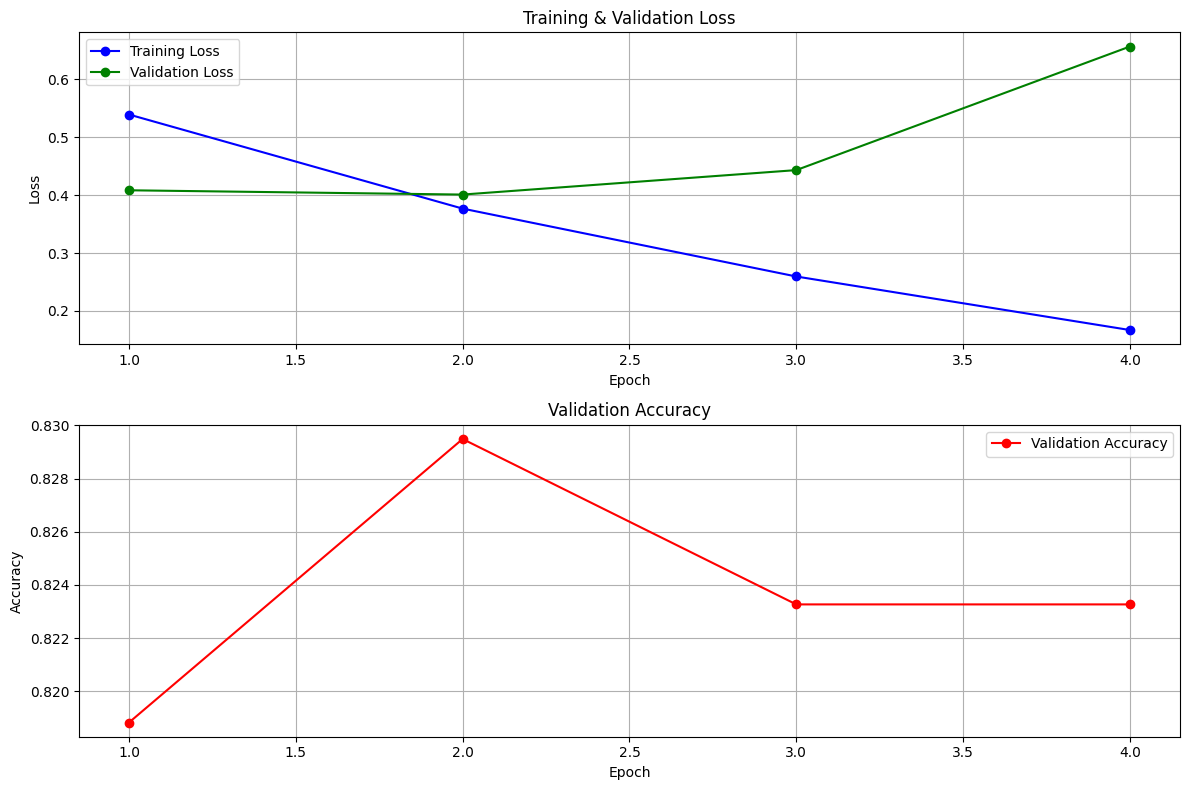

L∆∞u m√¥ h√¨nh v√†o ./model_save/


AttributeError: 'DistilBertForSentimentAnalysis' object has no attribute 'save_pretrained'

In [ ]:
# Main: Ki·ªÉm tra xem ƒë√£ c√≥ c√°c bi·∫øn c·∫ßn thi·∫øt ch∆∞a tr∆∞·ªõc khi hu·∫•n luy·ªán
try:
    # Ki·ªÉm tra c√°c bi·∫øn c·∫ßn thi·∫øt
    required_vars = [model, train_dataloader, validation_dataloader, optimizer, scheduler, loss_fn, device]

    # B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán
    model, training_stats = train_bert_model(
        model=model,
        train_dataloader=train_dataloader,
        validation_dataloader=validation_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn=loss_fn,
        device=device,
        epochs=4
    )

    # L∆∞u model
    output_dir = './model_save/'
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"L∆∞u m√¥ h√¨nh v√†o {output_dir}")

    # # L∆∞u model
    torch.save(model.state_dict(), os.path.join(output_dir, 'bert_sentiment_model.pth'))
    # Save model using save_pretrained
    # model.save_pretrained(output_dir)
    print("ƒê√£ l∆∞u m√¥ h√¨nh b·∫±ng save_pretrained")

    # L∆∞u tokenizer
    try:
        tokenizer.save_pretrained(output_dir)
        print("ƒê√£ l∆∞u tokenizer")
    except NameError:
        print("Tokenizer ch∆∞a ƒë∆∞·ª£c ƒë·ªãnh nghƒ©a")

except NameError as e:
    print(f"L·ªói: {e}")
    print("H√£y ƒë·∫£m b·∫£o b·∫°n ƒë√£ ch·∫°y c√°c b∆∞·ªõc tr∆∞·ªõc (b∆∞·ªõc 1, 2, 3) ƒë·ªÉ ƒë·ªãnh nghƒ©a c√°c bi·∫øn c·∫ßn thi·∫øt")

In [ ]:
def predict_sentiment(comment, model, tokenizer, device, max_length=128):
    model.eval()

    # Tokenize
    inputs = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_attention_mask=True
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Tensor logits tr·ª±c ti·∫øp (kh√¥ng ph·∫£i tuple)
          # outputs = tensor([[1.2, -0.3], [0.5, 2.1]])  # shape [batch_size, num_classes]
        # Tuple ch·ª©a nhi·ªÅu gi√° tr·ªã (logits ·ªü v·ªã tr√≠ ƒë·∫ßu ti√™n)
          # outputs = (tensor([[1.2, -0.3]]), hidden_states, attentions)  # logits l√† outputs[0]
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        probs = torch.softmax(logits, dim=1)
        confidence, predicted_label = torch.max(probs, dim=1)

    return [{
        "text": comment,
        "predicted_label": predicted_label.item(),
        "confidence": confidence.item()
    }]


In [ ]:
from google.colab import widgets
import ipywidgets as widgets
from IPython.display import display

# T·∫°o √¥ nh·∫≠p b√¨nh lu·∫≠n
input_box = widgets.Text(
    value='',
    placeholder='Nh·∫≠p b√¨nh lu·∫≠n c·ªßa b·∫°n t·∫°i ƒë√¢y...',
    description='B√¨nh lu·∫≠n:',
    layout=widgets.Layout(width='80%')
)

# N√∫t ƒë·ªÉ ch·∫°y d·ª± ƒëo√°n
button = widgets.Button(description="D·ª± ƒëo√°n", button_style='success')

# Hi·ªÉn th·ªã k·∫øt qu·∫£ d·ª± ƒëo√°n
output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        text = input_box.value.strip()
        if text:
            result = predict_sentiment(text, model, tokenizer, device)[0]
            print(f"VƒÉn b·∫£n: {result['text']}")
            print(f"‚Üí D·ª± ƒëo√°n: {'T√≠ch c·ª±c' if result['predicted_label'] == 1 else 'Ti√™u c·ª±c'}")
            print(f"‚Üí ƒê·ªô tin c·∫≠y: {result['confidence']:.4f}")
        else:
            print("Vui l√≤ng nh·∫≠p b√¨nh lu·∫≠n!")

# G√°n s·ª± ki·ªán cho n√∫t
button.on_click(on_button_click)

# Hi·ªÉn th·ªã widget
display(input_box, button, output)
